In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium import plugins
from IPython.display import IFrame

In [24]:
# pd.options.mode.dtype_backend = 'pyarrow'

In [25]:
df = pd.read_csv("..\\datasets\\nyc_taxi_trip_duration.csv", engine='pyarrow')

In [26]:
df["passenger_count"] = df["passenger_count"].astype("uint8")
df["vendor_id"] = df["vendor_id"].astype("uint8")
df["trip_duration"] = df["trip_duration"].astype("uint32")
df["store_and_fwd_flag"] = df["store_and_fwd_flag"].astype("string")
df["id"] = df["id"].astype("string")

In [27]:
df.describe()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,729322.000000,729322,729322,729322.000000,729322.000000,729322.000000,729322.000000,729322.000000,7.293220e+05
mean,1.535403,2016-04-01 11:17:42.123299584,2016-04-01 11:33:34.352432128,1.662055,-73.973513,40.750919,-73.973422,40.751775,9.522291e+02
min,1.000000,2016-01-01 00:01:14,2016-01-01 00:05:54,0.000000,-121.933342,34.712234,-121.933304,32.181141,1.000000e+00
25%,1.000000,2016-02-17 18:46:36.249999872,2016-02-17 19:00:30.500000,1.000000,-73.991859,40.737335,-73.991318,40.735931,3.970000e+02
50%,2.000000,2016-04-01 17:30:37.500000,2016-04-01 17:46:47.500000,1.000000,-73.981758,40.754070,-73.979759,40.754509,6.630000e+02
75%,2.000000,2016-05-15 07:13:01.249999872,2016-05-15 07:38:40.500000,2.000000,-73.967361,40.768314,-73.963036,40.769741,1.075000e+03
max,2.000000,2016-06-30 23:59:37,2016-07-01 23:02:03,9.000000,-65.897385,51.881084,-65.897385,43.921028,1.939736e+06
std,0.498745,NaN,NaN,1.312446,0.069754,0.033594,0.069588,0.036037,3.864626e+03


In [28]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


### Для начала рассмотрим координаты поездок на такси.

In [29]:
folium.Map(location=[40.5, -77.]).add_child(plugins.HeatMap(df[['pickup_latitude', 'pickup_longitude']].values)).save('geo_plot.html')
IFrame("plot_data.html", 1450, 700)

In [30]:
folium.Map(location=[40.5, -77.]).add_child(plugins.HeatMap(df[['dropoff_latitude', 'dropoff_longitude']].values)).save('geo_plot.html')
IFrame("plot_data.html", 1450, 700)

#### По картам можно заметить некоторые аномальные координаты.
#### Координаты указвающие на море, далеко в горы и а на очень дальний город San Jose (до которого где-то 4100 километров)

### Теперь посмотрим на сезонность в течении дня по часам.

<Axes: xlabel='dropoff_datetime'>

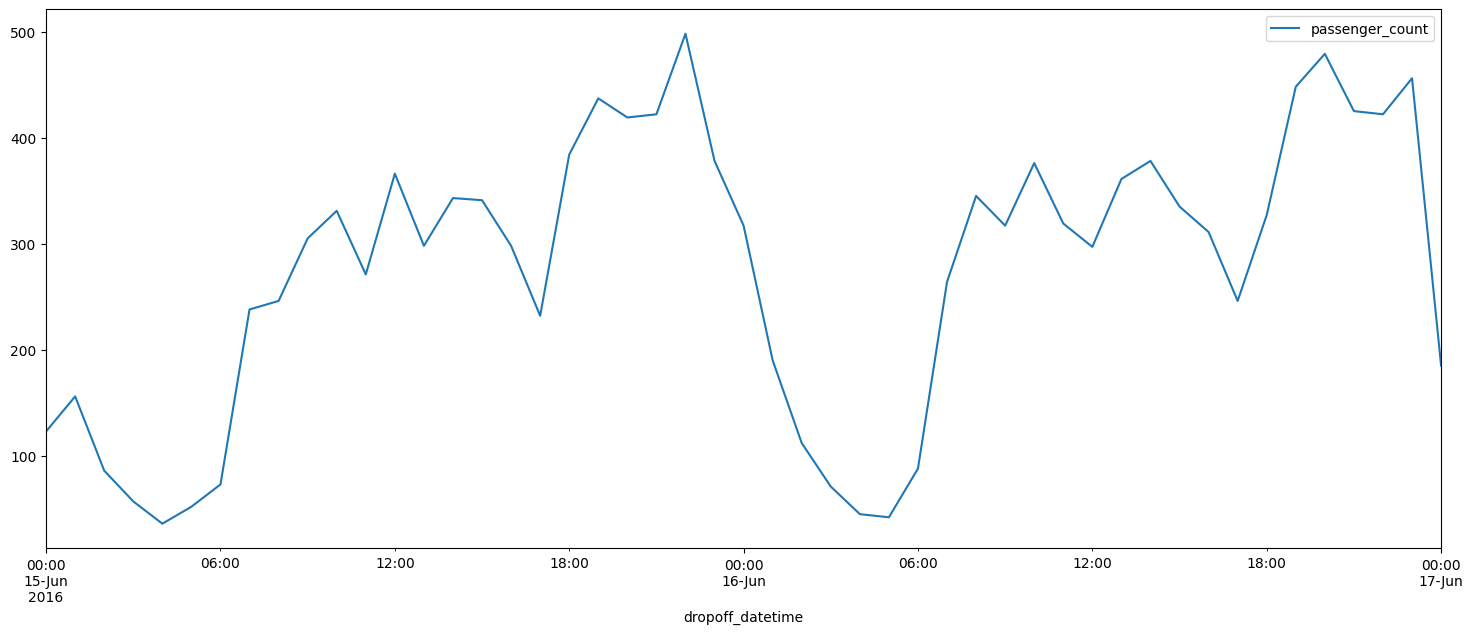

In [31]:
df_certain_month_day = df.loc[(df["dropoff_datetime"].dt.month == 6) & ((df["dropoff_datetime"].dt.day == 16) | (df["dropoff_datetime"].dt.day == 15))][["dropoff_datetime", "passenger_count"]].copy() 
df_certain_month_day["dropoff_datetime"] = df_certain_month_day["dropoff_datetime"].dt.round('H')
df_certain_month_day.groupby(by="dropoff_datetime").sum().reset_index().plot(x="dropoff_datetime", y="passenger_count", figsize=(18, 7))

### Явно видна сезонность.
#### В период с 2:00 по 6:00 количесвто перевозимых пассажиров минимальное.
#### В период с 19:00 по 23:00 количесвто перевозимых пассажиров максимальное.
#### В период с 7:00 по 16:00 количесвто перевозимых пассажиров среднее.

<Axes: xlabel='dropoff_datetime'>

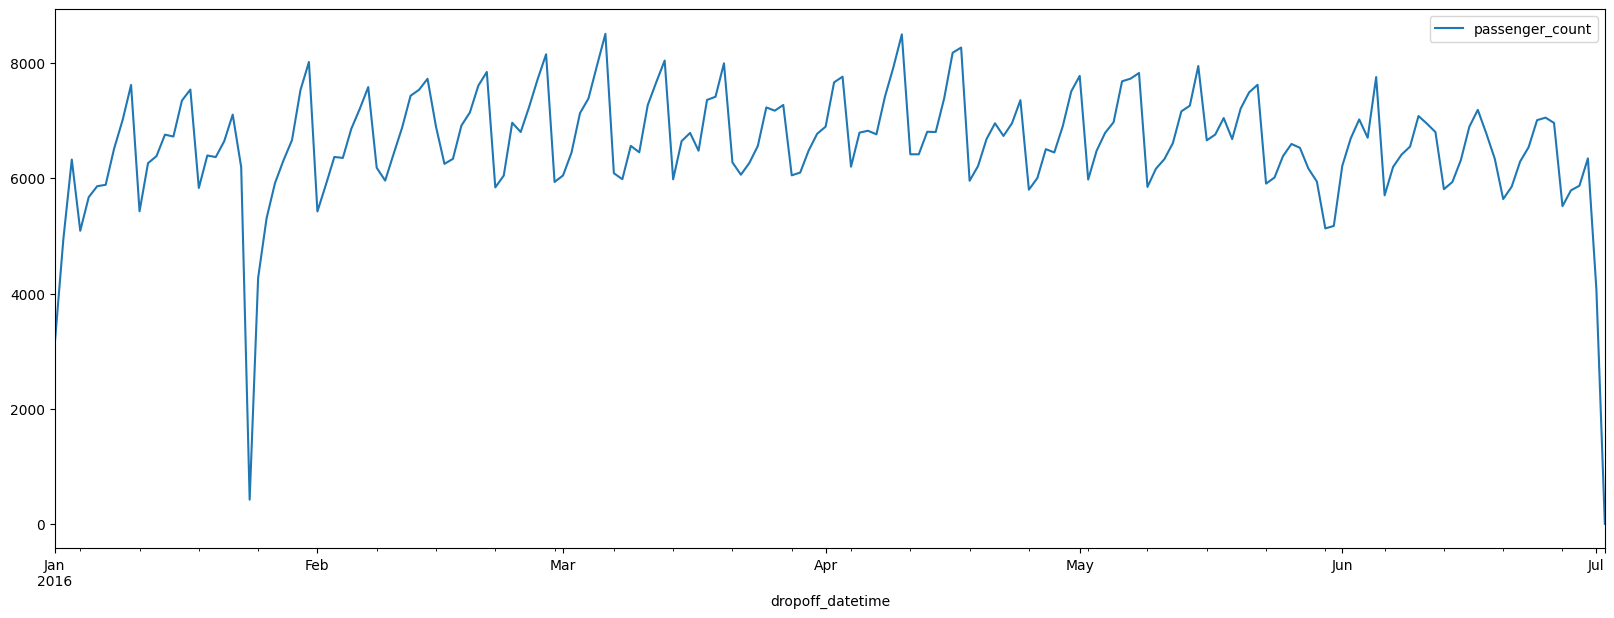

In [32]:
df_dates = df[["dropoff_datetime", "passenger_count"]].copy()
df_dates["dropoff_datetime"] = df_dates["dropoff_datetime"].dt.round('D')
df_dates = df_dates.groupby(by="dropoff_datetime").sum().reset_index()
df_dates.plot(x="dropoff_datetime", y="passenger_count", figsize=(20, 7))

### На графике можно заметить сезонность по дням недели и некоторые аномалии.

<Axes: xlabel='dropoff_datetime'>

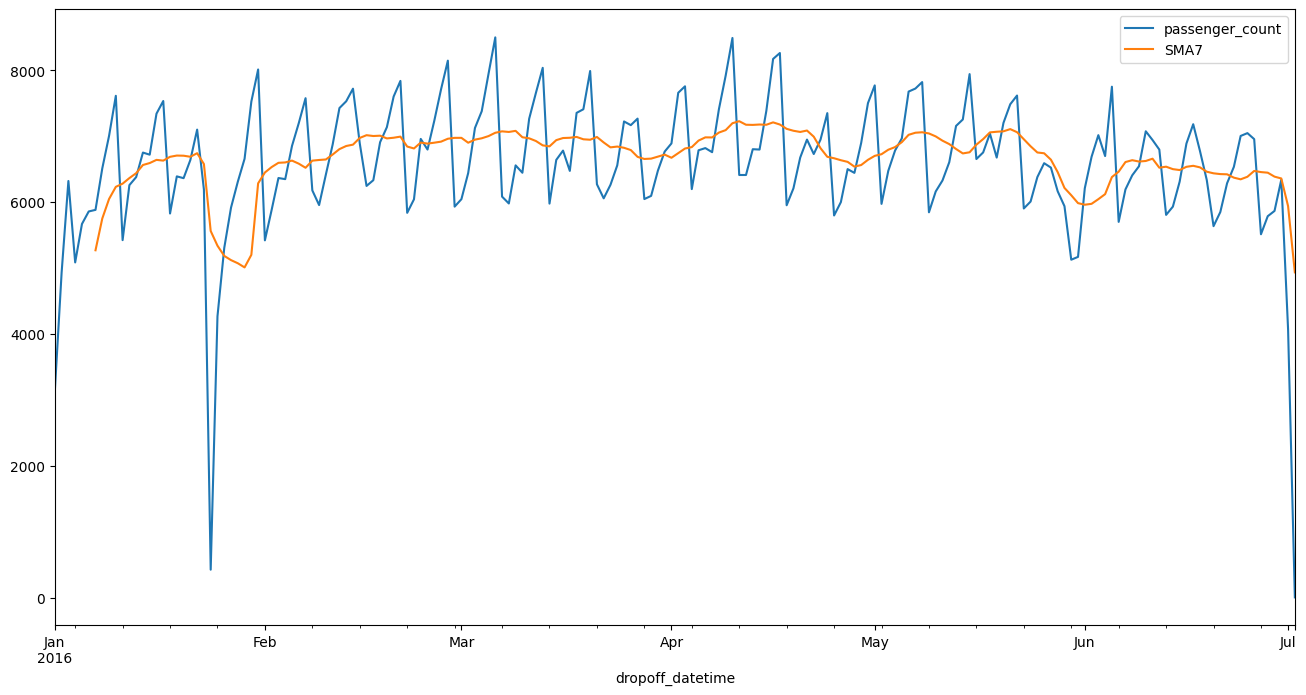

In [33]:
df_dates_a = df_dates.set_index("dropoff_datetime")
df_dates_a['SMA7'] = df_dates_a["passenger_count"].rolling(7).mean()
df_dates_a[['passenger_count', 'SMA7']].plot(figsize=(16, 8))

## Убрав сезонность при помощи скользящей средней, можно увидеть явные аномалии

#### Теперь рассмотрим отдельный месяц для наглядности.

<Axes: xlabel='dropoff_datetime'>

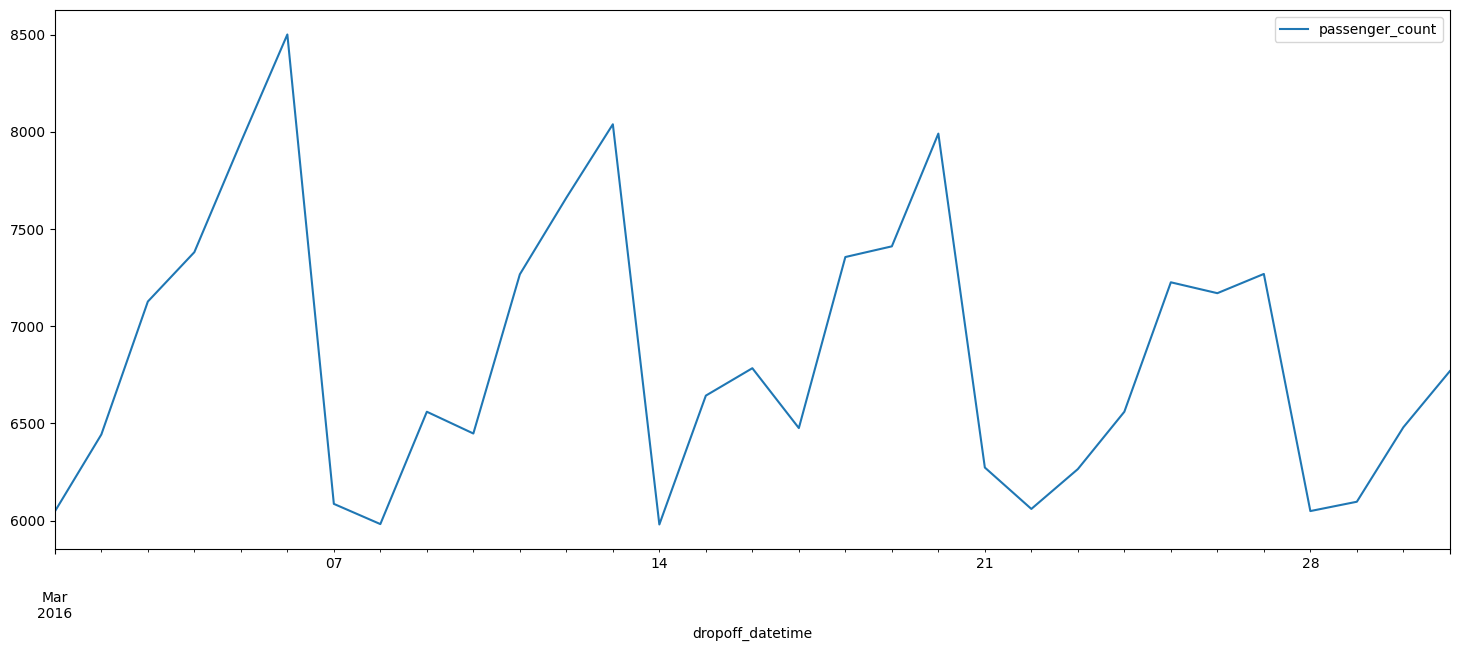

In [34]:
df_dates.loc[df_dates["dropoff_datetime"].dt.month == 3].plot(x="dropoff_datetime", y="passenger_count", figsize=(18, 7))

#### Можно увидеть что минимальное количество пассажиров фиксируется по понедельникам, а максимальное по субботам.

### Теперь посмотрим на количесвто поездок по месяцам.

<Axes: xlabel='month'>

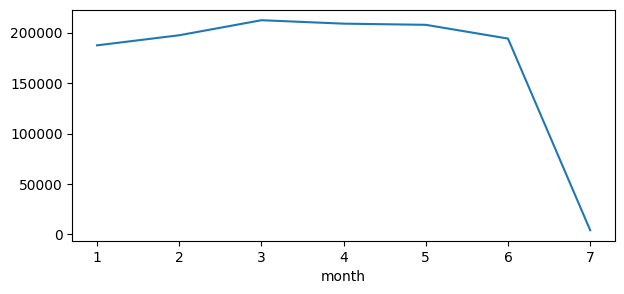

In [35]:
df_dates["month"] = df_dates["dropoff_datetime"].dt.month
df_dates.groupby(by="month")["passenger_count"].sum().plot(x="dropoff_datetime", y="passenger_count", figsize=(7, 3))

#### Можно заметить что выраженной сезонности нет, но присутсвует существенное падение количества пассажиров в 7 месяц.
#### Это объесняется тем, что в данном датасете существуют данные только от одного дня 7-го месяца.
#### Так же в целом глобальный тренд отсутсвует.

### Теперь перейдём к длине поездки.

<Axes: xlabel='dropoff_datetime'>

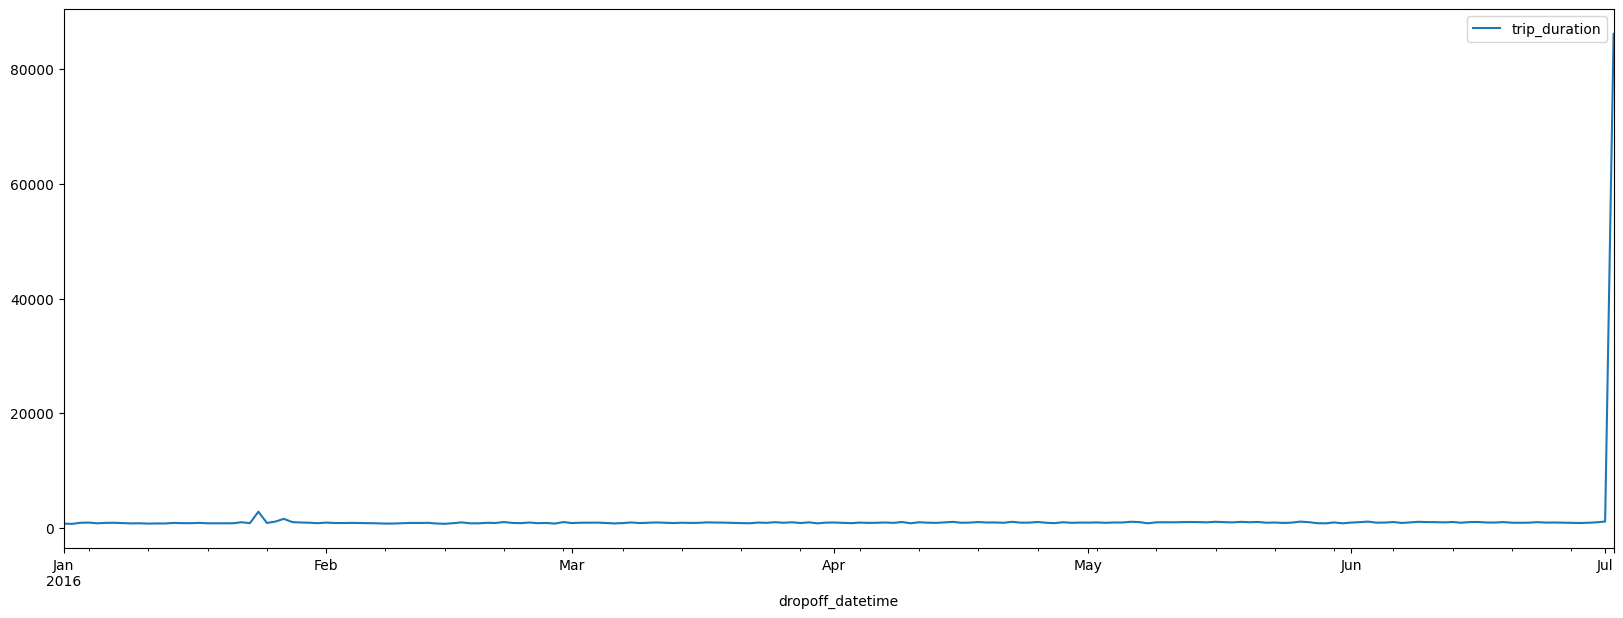

In [36]:
df_dates = df[["dropoff_datetime", "trip_duration"]].copy()
df_dates["dropoff_datetime"] = df_dates["dropoff_datetime"].dt.round('D')
df_dates = df_dates.groupby(by="dropoff_datetime").mean().reset_index()
df_dates.plot(x="dropoff_datetime", y="trip_duration", figsize=(20, 7))

#### Можно заметить, что сезонность отсутствует, но есть явные выбросы.

<Axes: xlabel='trip_duration'>

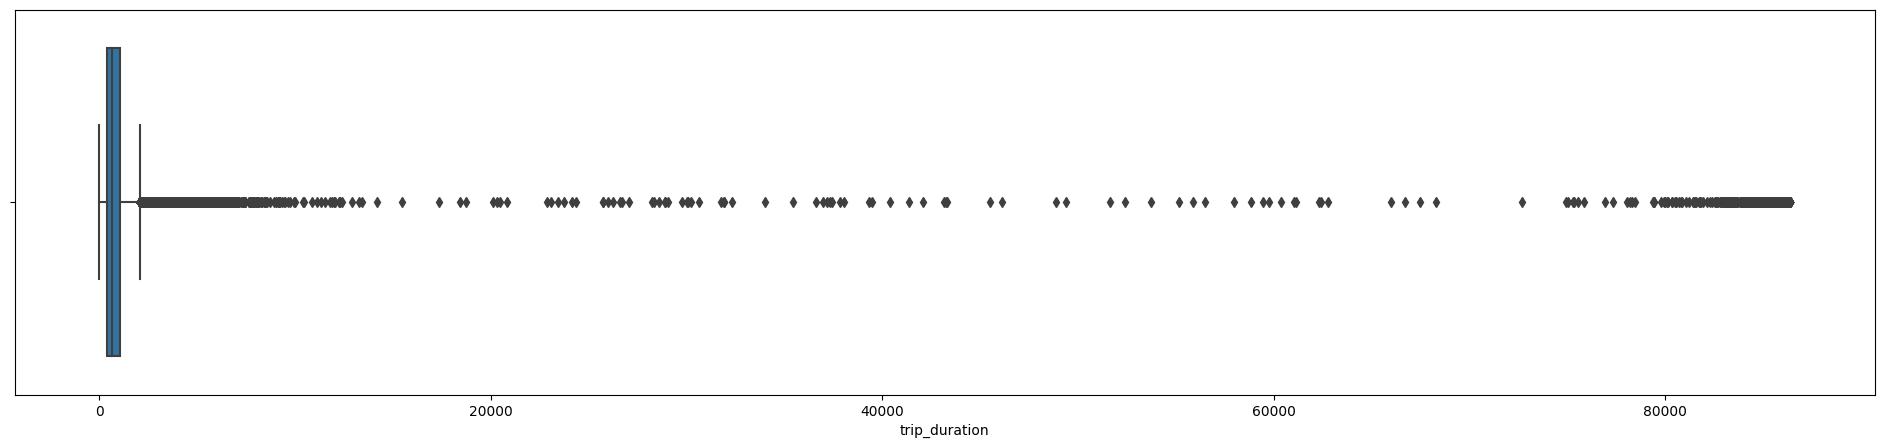

In [37]:
plt.figure(figsize=(24,5))
sns.boxplot(df[df['trip_duration'] < 1000000], x="trip_duration")

#### На этом графике его можно наглядно увидеть.

In [38]:
max_trip_duration = df["trip_duration"].max()
print(max_trip_duration)
print(max_trip_duration / 3600 / 24)
print(df[df["trip_duration"] == max_trip_duration])

1939736
22.450648148148147
              id  vendor_id     pickup_datetime    dropoff_datetime   
21813  id1864733          1 2016-01-05 00:19:42 2016-01-27 11:08:38  \

       passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude   
21813                1         -73.78965        40.643559          -73.95681  \

       dropoff_latitude store_and_fwd_flag  trip_duration  
21813         40.773087                  N        1939736  


#### Явно видна аномалия, одна из поездок длилась примерно 22 дня и перевозился всего 1 пассажир. А расстояние было примерно 20 км.

<Axes: >

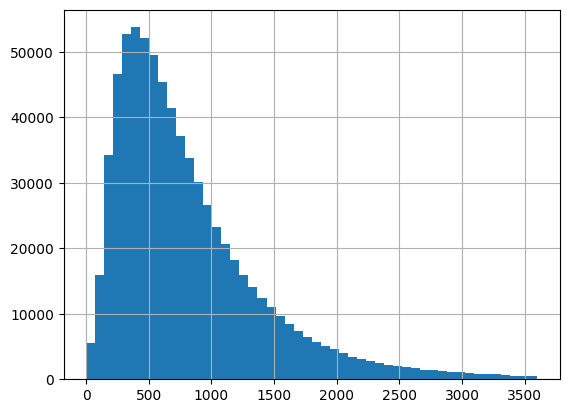

In [39]:
df.loc[df['trip_duration'] < 3600]['trip_duration'].hist(bins=50)

## распределение длитеностей поездок (не считая выбросы)